# OneStopEnglish: Data Cleaning and EDA
This script imports the One Stop English corpus, which consists of leveled text entries (beginner, intermediate, advanced) aligned to the same topic. Several features of the text entries are calculated using the `textstat` and `spacy` packages. These numerical features are then exported to a csv so they can be incoporated in a machine learning classification model that evaluates text complexity. Additional csv files are exported to finetune simpleGPT2 models for text generation. A list of the data prepared in this script is included below:
1. One column CSV files containing only text entries to be used to train NLP (simpleGPT2) models (**NOTE**, these can be created at the "sentence" and "passage" levels):
    1. _OSE\_adv\_int_: Matched advanced and intermediate texts, difficulty separated by indicator.
    1. _OSE\_adv\_ele_: Matched advanced and elementary texts, difficulty separated by indicator.
    1. _OSE\_int\_ele_: Matched intermediate adn elementary texts, difficulty separated by indicator.
1. A dataframe containing numerical characteristics about text entries to be used in training ML models to evaluate text complexity.
    1. _OSE\_TextFeat_

In [3]:
# Import packages
import numpy as np
import pandas as pd
import spacy
import nltk
import re
import textstat
import os
from os import listdir
from os.path import join, isfile
import chardet

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
# Function splits text, t, into sentences
def sent_break(t):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(t)
    return doc.sents

# Function counts the number of words in text t
def word_count(t):
    sents = sent_break(t)
    n_words = 0
    for s in sents:
        n_words += len([token for token in s])
    return n_words

# Function counts the number of sentences in text t
def sent_count(t):
    sents = sent_break(t)
    return len(list(sents))

# Function takes a list of words and returns a list in which all stop words are removed
def remove_stop_words(wordlist):
    # Get all English stop words
    stops = set(stopwords.words("english"))  
    nostops = [w for w in wordlist if w not in stops]
    return nostops

# Function takes a list of words and returns a list of word stems
def stem_words(wordlist):
    # Initialize object to stem words
    ps = PorterStemmer()
    stems = [ps.stem(w) for w in wordlist]
    return stems

In [24]:
# Sets option to display all text in pandas dataframes
pd.set_option('display.max_colwidth', None)

# Data Type: Either "TextByReadingLevel" or "SentenceAligned"
DatType = 'TextByReadingLevel/'

# Get file path for OneStopEnglish Corpus from individual TXT files.
RawDat = '../data_raw/OneStopEng/' + DatType

# Set location to save clean data
ClnDat = '../data_clean/'

# Set location to save figures
Figs = '../figures/'

In [6]:
# For some reason there are two "Int" files--do not import the first, as it contains errors
SubDir = [join(RawDat, f)+'/' for f in listdir(RawDat) if f != 'Int-Txt']

# Load all texts into pandas data frame
TextDF = pd.DataFrame()

for s in SubDir:

    TextFiles = listdir(s)

    for t in TextFiles:
        # There is a hidden .ds_store file that should be skipped when importing data
        if t == '.DS_Store':
            pass
        else:
            with open(s + t, 'rb') as rawdat:
                result = chardet.detect(rawdat.read(10000))

                
            file = open(s + t, 'r', encoding = result['encoding'])
            text = file.read()
            file.close()

            # Append text data and file name to dataframe
            TextDF = TextDF.append({'file_nm' : t,
                                    'text' : text},
                                   ignore_index = True)

In [7]:
# Isolate name and level of text
TextDF['name'] = TextDF['file_nm'].str[:-8]
TextDF['level'] = TextDF['file_nm'].str[-7:-4]
TextDF['text'] = TextDF['text'].apply(str)

# TextDF.groupby(['level'])['text'].count()

# Intermediate text is labeled--this should be removed
# TextDF['text'] = TextDF['text'].map(lambda x: x.lstrip('Intermediate'))
# TextDF['text'] = TextDF['text'].str.replace('\n', ' ')

In [8]:
# Pivot text to level
TextDF_w = TextDF.pivot(index = ['name'], columns = ['level'], values = ['text']).reset_index()

# Flatten column index of pivot table
TextDF_w.columns = TextDF_w.columns.map('_'.join).str.strip('_')

# Match text pairs accross levels to train GPT2 Model
TextDF_w['adv_int'] = TextDF_w['text_adv'] + '\n |<endoflevelone>| \n' + TextDF_w['text_int']
TextDF_w['adv_ele'] = TextDF_w['text_adv'] + '\n |<endoflevelone>| \n' + TextDF_w['text_ele']
TextDF_w['int_ele'] = TextDF_w['text_int'] + '\n |<endoflevelone>| \n' + TextDF_w['text_ele']

# Export matched text columns to csv file to finetune SimpleGPT2, need to specify encoding or odd figures are saved
# One column must be included for file to successfully be read into SimpleGPT2
for lev in ['adv_int', 'adv_ele', 'int_ele']:
    TextDF_w[lev] = TextDF_w[lev].apply(str)
    TextDF_w[lev].to_csv(ClnDat+'OSE_'+lev+'.csv', encoding = 'utf-8-sig', index = False)

In [9]:
# Clean text (text_c) by lowering, removing numbers, removing symbols, and reducing to single space
TextDF['text_c'] = TextDF['text'].str.lower().str.replace(r'[^a-zA-Z\s]', '')
TextDF['text_c'] = TextDF['text_c'].str.replace(r'\n', ' ').str.replace(r'\s+\s', ' ')

In [10]:
# This step is separate from the other text statistic computations because it takes a longer time to run
# Compute text difficulty using textstat
TextDF['difficulty'] = TextDF['text'].apply(textstat.flesch_reading_ease)

# Compute sentence length
TextDF['n_sent'] = TextDF['text'].apply(sent_count)

In [11]:
# Compute additional text statistics
TextDF['n_syll'] = TextDF['text'].apply(textstat.syllable_count) # Number of syllables
TextDF['n_lex'] = TextDF['text'].apply(textstat.lexicon_count) # Number of words
TextDF['lex_sent'] = TextDF['n_lex']/TextDF['n_sent'] # Word to sentence ratio
TextDF['syll_lex'] = TextDF['n_syll']/TextDF['n_lex'] # Syllable to word ratio

# Save text statistc data to csv
TextDF.to_csv(ClnDat+'OSE_TextFeat.csv', encoding = 'utf-8-sig', index = False)

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_sent, dtype: object

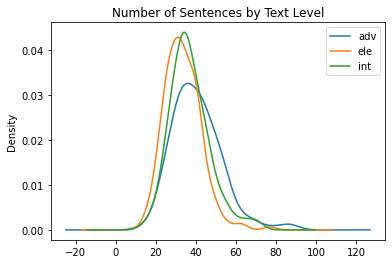

In [12]:
TextDF.groupby('level')['n_sent'].plot(kind = 'kde', legend = True, #alpha = 0.5, 
                                       title = 'Number of Sentences by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_syll, dtype: object

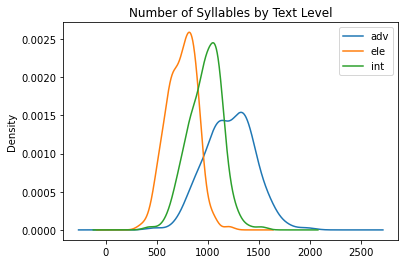

In [13]:
TextDF.groupby('level')['n_syll'].plot(kind = 'kde', legend = True,
                                       title = 'Number of Syllables by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_lex, dtype: object

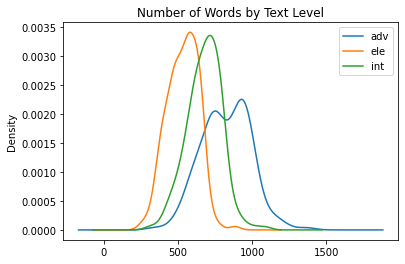

In [14]:
TextDF.groupby('level')['n_lex'].plot(kind = 'kde', legend = True,
                                      title = 'Number of Words by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: lex_sent, dtype: object

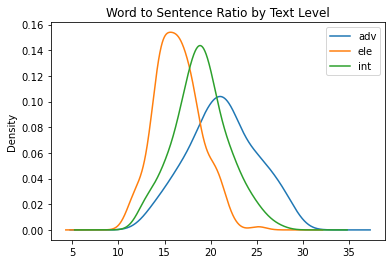

In [15]:
TextDF.groupby('level')['lex_sent'].plot(kind = 'kde', legend = True,
                                         title = 'Word to Sentence Ratio by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: syll_lex, dtype: object

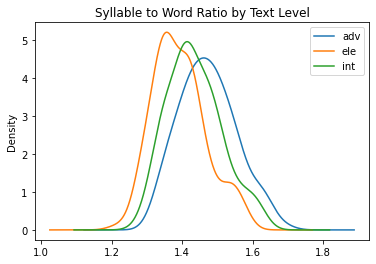

In [16]:
TextDF.groupby('level')['syll_lex'].plot(kind = 'kde', legend = True, #alpha = 0.5, 
                                         title = 'Syllable to Word Ratio by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: difficulty, dtype: object

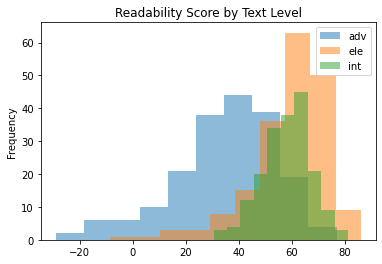

In [15]:
TextDF.groupby('level')['difficulty'].plot(kind = 'hist', legend = True, alpha = 0.5, 
                                           title = 'Readability Score by Text Level')

In [17]:
# Specify data to be loaded and cleaned
DatType = 'SentenceAligned/'

# Get file path for OneStopEnglish Corpus from individual TXT files.
RawDat = '../data_raw/OneStopEng/' + DatType

t_files = ['ADV-ELE.txt', 'ADV-INT.txt', 'ELE-INT.txt']

TextDF_all = pd.DataFrame()

for t in t_files:
        
    # Create labels depending on which file inported
    if t == 'ADV-ELE.txt':
        l1 = 'adv'
        l2 = 'ele'
    if t == 'ADV-INT.txt':
        l1 = 'adv'
        l2 = 'int'
    if t == 'ELE-INT.txt':
        l1 = 'ele'
        l2 = 'int'
        
    with open(RawDat + t, 'rb') as rawdat:
        result = chardet.detect(rawdat.read(10000))

    file = open(RawDat + t, 'r', encoding = result['encoding'])
    text = file.read()
    file.close()

    text = text.split('\n')

    TextDF = pd.DataFrame(text, columns = ['text'])
    TextDF = TextDF[~TextDF['text'].isin(['*******', '', ' '])].reset_index().drop(columns = 'index')
    TextDF['level'] = [l1, l2]*int(len(TextDF.index)/2)
    
    # Make dataframe with sentences listed by level
    TextDF_all = TextDF_all.append(TextDF)
    
    TextDF['label'] = list(np.repeat(list(range(1, int(len(TextDF.index)/2)+1)), 2))
    TextDF['label'] = 's' + TextDF['label'].apply(str)

    # Pivot text to level
    TextDF = TextDF.pivot(index = ['label'], columns = ['level'], values = ['text']).reset_index()

    # Flatten column index of pivot table
    TextDF.columns = TextDF.columns.map('_'.join).str.strip('_')
    
    # Create text variable in which more difficult sentence is above easier sentence, separated by |<endoflevelone>|
    if t == 'ELE-INT.txt':
        l1 = 'int'
        l2 = 'ele'
    else:
        pass
    
    NewVar = l1+'_'+l2
    TextDF[NewVar] = TextDF['text_'+l1] + '\n |<endoflevelone>| \n' + TextDF['text_'+l2]
    TextDF = TextDF.drop_duplicates()

    # Export TextDF to csv file
    TextDF.to_csv(ClnDat+'OSE_'+NewVar+'_sent.csv', encoding = 'utf-8-sig', index = False)

TextDF = TextDF_all.drop_duplicates().reset_index()

In [23]:
TextDF_all['sent_id'] = np.repeat(range(1, int(len(TextDF_all.index)/2+1)), 2)
TextDF_all

,text,level,sent_id
0,"The Seattle-based company has applied for its brand to be a top-level domain name (currently .com), but the South American governments argue this would prevent the use of this internet address for environmental protection, the promotion of indigenous rights and other public interest uses.",adv,1
1,"Amazon has asked for its company name to be a top-level domain name (currently .com), but the South American governments say this would stop the use of this internet address for environmental protection, indigenous rights and other public interest uses.",ele,1
2,"Until now, the differences between commercial, governmental and other types of identity were easily distinguished in every internet address by .com, .gov and 20 other categories.",adv,2
3,"Until now, the differences between commercial, governmental and other types of identity were easy to see in every internet address by the use of .com, .gov and 20 other categories.",ele,2
4,"Amazon has applied for dozens of new domains, including .shop, .song, .book and .kindle.",adv,3
...,...,...,...
3343,"The charity National Trust, which employs many of its seasonal workers on zero-hours contracts, said it offered the same pay and bene ts to those workers, pro rata, as full-time staff, but needed some workers to be on more exible contracts.",int,5992
3344,"Politician Chuka Umunna said, While some employees welcome the exibility of zero-hours contracts, for many, zero-hours contracts leave them insecure and unsure of when work will come, he said.",ele,5993
3345,"While some employees welcome the exibility of such contracts, for many, zero-hours contracts leave them insecure and unsure of when work will come, he said.",int,5993
3346,"The poll shows that 17% of employers in the private sector use zero-hours contracts, lower than the 34% of organizations in the voluntary sector and 24% in the public sector.",ele,5994


In [32]:
# Compute text statistics
TextDF['difficulty'] = TextDF['text'].apply(textstat.flesch_reading_ease) # Text readability score (flesch reading)
TextDF['n_sent'] = TextDF['text'].apply(textstat.sentence_count) # Number of sentences (all are 1, but needed for other calculations)
TextDF['n_syll'] = TextDF['text'].apply(textstat.syllable_count) # Number of syllables
TextDF['n_lex'] = TextDF['text'].apply(textstat.lexicon_count) # Number of words
TextDF['lex_sent'] = TextDF['n_lex']/TextDF['n_sent'] # Word to sentence ratio
TextDF['syll_lex'] = TextDF['n_syll']/TextDF['n_lex'] # Syllable to word ratio

# Remove numbers and symbols and convert string to lower
TextDF['text_c'] = TextDF['text'].str.replace(r'[^a-zA-Z\s+]', '').str.lower()

# Replace double spaces with single space
TextDF['text_c'] = TextDF['text_c'].str.replace(r'\s+\s+', ' ')

# Tokenize text entries
TextDF['text_c'] = TextDF['text_c'].apply(word_tokenize)

# Remove stop words
TextDF['text_c'] = TextDF['text_c'].apply(remove_stop_words)

# Mark words with parts of speech
TextDF['pos_tags'] = TextDF['text_c'].apply(nltk.pos_tag)

# Stem text entries
# TextDF['text_c'] = TextDF['text_c'].apply(stem_words)



# Export data to file
# TextDF.to_csv(ClnDat+'OSE_sent_lev.csv', encoding = 'utf-8-sig', index = False)

In [37]:
TextDF['pos_tags'][[0]]

0    [(seattlebased, VBN), (company, NN), (applied, VBN), (brand, NN), (toplevel, NN), (domain, NN), (name, NN), (currently, RB), (com, VBZ), (south, JJ), (american, JJ), (governments, NNS), (argue, NN), (would, MD), (prevent, VB), (use, NN), (internet, NN), (address, NN), (environmental, JJ), (protection, NN), (promotion, NN), (indigenous, JJ), (rights, NNS), (public, JJ), (interest, NN), (uses, NNS)]
Name: pos_tags, dtype: object

In [ ]:
# DO NOT USE--IMPORTS TEXT FILE USING PANDAS, AND SOME ROWS ARE MISALIGNED
# THERE IS ALSO AN ISSUE LOADING THE 'ELE-INT' FILE USING PANDAS

# Create cleaned sentence aligned files for text generation analysis

# Data Type: Either "TextByReadingLevel" or "SentenceAligned"
DatType = 'SentenceAligned/'

# Get file path for OneStopEnglish Corpus from individual TXT files.
RawDat = os.getcwd() + '/data_raw/OneStopEng/' + DatType

t_files = ['ADV-ELE.txt', 'ADV-INT.txt', 'ELE-INT.txt']

for t in t_files:
    
    # Read in txt file
    TextDF = pd.read_csv(RawDat + t, sep = '\n', header = None)
    
    # Create labels depending on which file inported
    if t == 'ADV-ELE.txt':
        l1 = 'adv'
        l2 = 'ele'
    if t == 'ADV-INT.txt':
        l1 = 'adv'
        l2 = 'int'
    if t == 'ELE-INT.txt':
        l1 = 'ele'
        l2 = 'int'
        
    TextDF.columns = ['text']
    TextDF['level'] = [l1, l2, 'split']*int(len(TextDF.index)/3)
    TextDF['label'] = list(np.repeat(list(range(1, int(len(TextDF.index)/3)+1)), 3))
    TextDF = TextDF[TextDF['level'] != 'split'].reset_index().drop(columns = ['index'])
    TextDF['label'] = 's' + TextDF['label'].apply(str)

    # Pivot text to level
    TextDF = TextDF.pivot(index = ['label'], columns = ['level'], values = ['text']).reset_index()

    # Flatten column index of pivot table
    TextDF.columns = TextDF.columns.map('_'.join).str.strip('_')
    
    # Create text variable in which more difficult sentence is above easier sentence, separated by |<endoflevelone>|
    if t == 'ELE-INT.txt':
        l1 = 'int'
        l2 = 'ele'
    else:
        pass
    
    NewVar = l1+'_'+l2
    TextDF[NewVar] = TextDF['text_'+l1] + '\n |<endoflevelone>| \n' + TextDF['text_'+l2]
    
    # Export TextDF to csv file
    TextDF[NewVar].to_csv(ClnDat+'OSE_'+NewVar+'_sent.csv', encoding = 'utf-8-sig', index = False)

In [ ]:
###################################
# IMPORT DATA STORED IN CSV FILES #
###################################

# Get file path to OneStopEnglish Corpus including combined CSV files.
FilePath = os.getcwd() + '/OneStopEng/TextOneCSVPerFile/'

# Texts are organized by difficulty level
Files = listdir(FilePath)

# Import all texts into pandas dataframe
oseDF = pd.DataFrame() # Initialize dataframe

# Loop through all files
for f in Files:
    
    # Files have different encodings
    # Find the encoding for each file and use that in read_csv command
    with open(FilePath + f, 'rb') as rawdat:
        result = chardet.detect(rawdat.read(10000))
        
    oseDFA = pd.read_csv(FilePath + f, encoding = result['encoding'])
    oseDFA['name'] = f
    
    oseDF = oseDF.append(oseDFA)

In [ ]:
# Code used for development

# Create cleaned sentence aligned files for text generation analysis

# Data Type: Either "TextByReadingLevel" or "SentenceAligned"
DatType = 'SentenceAligned/'

# Get file path for OneStopEnglish Corpus from individual TXT files.
RawDat = os.getcwd() + '/data_raw/OneStopEng/' + DatType

t_files = ['ADV-ELE.txt', 'ADV-INT.txt', 'ELE-INT.txt']
t = 'ADV-ELE.txt'

l1 = 'adv'
l2 = 'ele'
with open(RawDat + t, 'rb') as rawdat:
    result = chardet.detect(rawdat.read(10000))
    
file = open(RawDat + t, 'r', encoding = result['encoding'])
text = file.read()
file.close()

text = text.split('\n')

TextDF = pd.DataFrame(text, columns = ['text'])
TextDF = TextDF[~TextDF['text'].isin(['*******', '', ' '])].reset_index().drop(columns = 'index')
TextDF['level'] = [l1, l2]*int(len(TextDF.index)/2)
TextDF['label'] = list(np.repeat(list(range(1, int(len(TextDF.index)/2)+1)), 2))
TextDF['label'] = 's' + TextDF['label'].apply(str)
TextDF = TextDF.pivot(index = ['label'], columns = ['level'], values = ['text']).reset_index()
TextDF